In [1]:
from greedy_mcmc_attack import *
from data_collection.recordings import *
import sys
sys.path.append("../../")
from src.models.gcn import *
from src.models.gat import *
from src.models.gsage import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# dataset_directory = "../Cora"
cora_dataset = Planetoid(root='', name='Cora')
data = cora_dataset[0].to(device)
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [4]:
edges_to_add = None

In [5]:
model = GCN(data.x.shape[1], cora_dataset.num_classes, [16]).to(device)

In [6]:
model_save_path = "../models/cora_gcn_model.pth"
list_save_path = "../attacks/cora_gcn_edges.pth"
# # multi_metattack_edges_list.pth
# list_save_path = "multi_metattack_edges_list.pth"

In [7]:
model, edges_to_add, train = load_model_and_edges(model_save_path, list_save_path, model, device)

In [8]:
# Get initial accuracy
initial_loss, initial_accuracy = train.test(data)
print(f"Initial Accuracy: {initial_accuracy}")
print(f"Initial Loss: {initial_loss}")

Initial Accuracy: 0.759
Initial Loss: 1.91191828250885


In [9]:
G, initial_edge_count, ptb_rate, budget = initialize(data, _ptb_rate=0.15)

In [10]:
full_metattack_acc, full_metattack_loss, full_metattack_itrs = two_phase_attack_mcmc(data, train, model, 0.0, edges_to_add, binary_fn, constant_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/395 [00:00<?, ?it/s]

In [11]:
splits = [0.0, 0.5, 0.7, 0.9]
# splits = [0.9]
split_dic_acc = defaultdict(list)
split_dic_loss = defaultdict(list)
itrs_one = defaultdict(int)

In [12]:
for s in splits:
    if s == 0.0:
        split_dic_acc[s], split_dic_loss[s], itrs_one[s] = full_metattack_acc, full_metattack_loss, full_metattack_itrs
    else:
        split_dic_acc[s], split_dic_loss[s], itrs_one[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, constant_fn, device, is_reversed=True, verbose=True)

Peturbing graph...:   0%|          | 0/197 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 15, Selected: 10
Attempt: 25, Selected: 20
Attempt: 35, Selected: 30
Attempt: 45, Selected: 40
Attempt: 55, Selected: 50
Attempt: 65, Selected: 60
Attempt: 75, Selected: 70
Attempt: 86, Selected: 80
Attempt: 96, Selected: 90
Attempt: 106, Selected: 100
Attempt: 116, Selected: 110
Attempt: 126, Selected: 120
Attempt: 136, Selected: 130
Attempt: 146, Selected: 140
Attempt: 156, Selected: 150
Attempt: 166, Selected: 160
Attempt: 176, Selected: 170
Attempt: 186, Selected: 180
Attempt: 196, Selected: 190


Peturbing graph...:   0%|          | 0/118 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 11, Selected: 10
Attempt: 21, Selected: 20
Attempt: 31, Selected: 30
Attempt: 41, Selected: 40
Attempt: 51, Selected: 50
Attempt: 61, Selected: 60
Attempt: 71, Selected: 70
Attempt: 81, Selected: 80
Attempt: 91, Selected: 90
Attempt: 101, Selected: 100
Attempt: 111, Selected: 110
Attempt: 121, Selected: 120
Attempt: 131, Selected: 130
Attempt: 142, Selected: 140
Attempt: 152, Selected: 150
Attempt: 162, Selected: 160
Attempt: 172, Selected: 170
Attempt: 183, Selected: 180
Attempt: 193, Selected: 190
Attempt: 203, Selected: 200
Attempt: 213, Selected: 210
Attempt: 223, Selected: 220
Attempt: 233, Selected: 230
Attempt: 243, Selected: 240
Attempt: 253, Selected: 250
Attempt: 263, Selected: 260
Attempt: 273, Selected: 270


Peturbing graph...:   0%|          | 0/39 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 11, Selected: 10
Attempt: 21, Selected: 20
Attempt: 31, Selected: 30
Attempt: 41, Selected: 40
Attempt: 51, Selected: 50
Attempt: 61, Selected: 60
Attempt: 71, Selected: 70
Attempt: 81, Selected: 80
Attempt: 91, Selected: 90
Attempt: 101, Selected: 100
Attempt: 111, Selected: 110
Attempt: 121, Selected: 120
Attempt: 131, Selected: 130
Attempt: 142, Selected: 140
Attempt: 152, Selected: 150
Attempt: 162, Selected: 160
Attempt: 172, Selected: 170
Attempt: 183, Selected: 180
Attempt: 193, Selected: 190
Attempt: 203, Selected: 200
Attempt: 213, Selected: 210
Attempt: 223, Selected: 220
Attempt: 233, Selected: 230
Attempt: 243, Selected: 240
Attempt: 253, Selected: 250
Attempt: 263, Selected: 260
Attempt: 273, Selected: 270
Attempt: 283, Selected: 280
Attempt: 293, Selected: 290
Attempt: 305, Selected: 300
Attempt: 315, Selected: 310
Attempt: 325, Selected: 320
Attempt: 335, Selected: 330
Attempt: 345, Selected: 340
Attempt: 356, Sele

In [13]:
record1 = Recording(split_dic_loss, split_dic_acc, itrs_one, Model.GCN, Dataset.CORA, AcceptFn.CONSTANT, SelectFn.NONE, Reverse.REVERSED)
record1.save(f'data_collection/{"greedy"}_{"gcn"}_{"cora"}_{"constant"}_{"reversed"}_results.pkl')

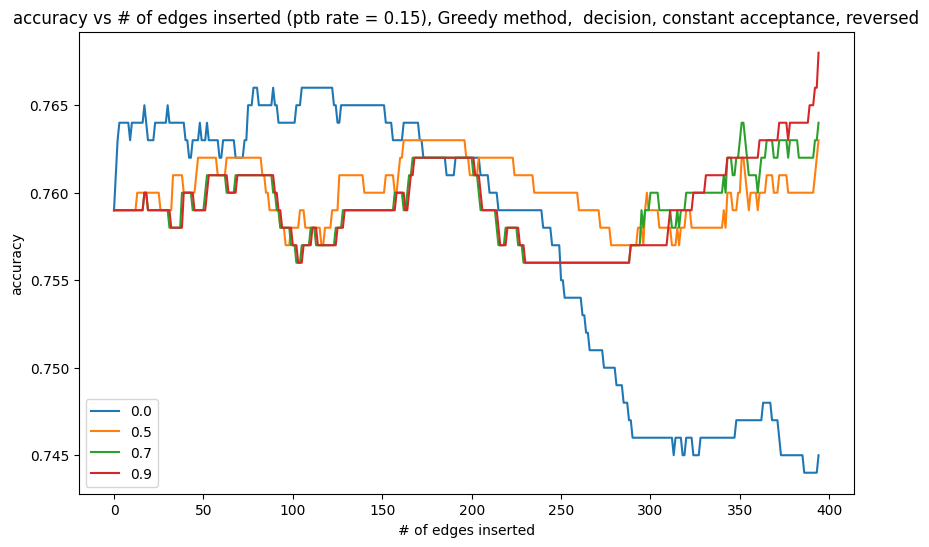

In [14]:
plot_results(split_dic_acc, ptb_rate, "Greedy", "", "constant", "accuracy", "reversed")

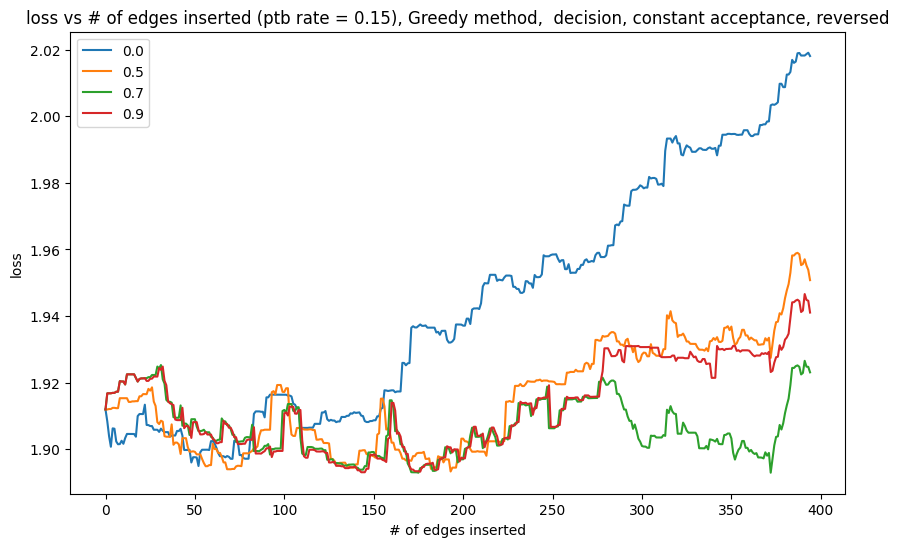

In [15]:
plot_results(split_dic_loss, ptb_rate, "Greedy", "", "constant", "loss", "reversed")

##### ideally, we could show some metric, where (change in loss after hidden for %) > (% * max change in loss)

In [16]:
split_dic_decreasing_acc = defaultdict(list)
itrs_two = defaultdict(int)
split_dic_decreasing_loss = defaultdict(list)

In [17]:
for s in splits:
    if s == 0.0:
        split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = full_metattack_acc, full_metattack_loss, full_metattack_itrs
    else:
        split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, increasing_fn, device, is_reversed=True, verbose=True)

Peturbing graph...:   0%|          | 0/197 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 5, Selected: 0
Attempt: 20, Selected: 10
Attempt: 30, Selected: 20
Attempt: 45, Selected: 30
Attempt: 58, Selected: 40
Attempt: 69, Selected: 50
Attempt: 79, Selected: 60
Attempt: 90, Selected: 70
Attempt: 101, Selected: 80
Attempt: 113, Selected: 90
Attempt: 123, Selected: 100
Attempt: 124, Selected: 100
Attempt: 135, Selected: 110
Attempt: 145, Selected: 120
Attempt: 155, Selected: 130
Attempt: 167, Selected: 140
Attempt: 178, Selected: 150
Attempt: 189, Selected: 160
Attempt: 199, Selected: 170
Attempt: 209, Selected: 180
Attempt: 219, Selected: 190


Peturbing graph...:   0%|          | 0/118 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 17, Selected: 10
Attempt: 18, Selected: 10
Attempt: 37, Selected: 20
Attempt: 54, Selected: 30
Attempt: 70, Selected: 40
Attempt: 71, Selected: 40
Attempt: 72, Selected: 40
Attempt: 83, Selected: 50
Attempt: 84, Selected: 50
Attempt: 96, Selected: 60
Attempt: 107, Selected: 70
Attempt: 118, Selected: 80
Attempt: 129, Selected: 90
Attempt: 130, Selected: 90
Attempt: 141, Selected: 100
Attempt: 142, Selected: 100
Attempt: 152, Selected: 110
Attempt: 163, Selected: 120
Attempt: 175, Selected: 130
Attempt: 187, Selected: 140
Attempt: 197, Selected: 150
Attempt: 207, Selected: 160
Attempt: 217, Selected: 170
Attempt: 227, Selected: 180
Attempt: 239, Selected: 190
Attempt: 249, Selected: 200
Attempt: 262, Selected: 210
Attempt: 272, Selected: 220
Attempt: 283, Selected: 230
Attempt: 293, Selected: 240
Attempt: 304, Selected: 250
Attempt: 316, Selected: 260
Attempt: 327, Selected: 270


Peturbing graph...:   0%|          | 0/39 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 5, Selected: 0
Attempt: 21, Selected: 10
Attempt: 37, Selected: 20
Attempt: 52, Selected: 30
Attempt: 53, Selected: 30
Attempt: 54, Selected: 30
Attempt: 66, Selected: 40
Attempt: 67, Selected: 40
Attempt: 81, Selected: 50
Attempt: 92, Selected: 60
Attempt: 93, Selected: 60
Attempt: 94, Selected: 60
Attempt: 95, Selected: 60
Attempt: 106, Selected: 70
Attempt: 107, Selected: 70
Attempt: 119, Selected: 80
Attempt: 130, Selected: 90
Attempt: 141, Selected: 100
Attempt: 151, Selected: 110
Attempt: 163, Selected: 120
Attempt: 164, Selected: 120
Attempt: 165, Selected: 120
Attempt: 176, Selected: 130
Attempt: 188, Selected: 140
Attempt: 199, Selected: 150
Attempt: 209, Selected: 160
Attempt: 220, Selected: 170
Attempt: 230, Selected: 180
Attempt: 240, Selected: 190
Attempt: 250, Selected: 200
Attempt: 251, Selected: 200
Attempt: 251, Selected: 200
Attempt: 252, Se

In [18]:
record1 = Recording(split_dic_decreasing_loss, split_dic_decreasing_acc, itrs_two, Model.GCN, Dataset.CORA, AcceptFn.INCREASING, SelectFn.NONE, Reverse.REVERSED)
record1.save(f'data_collection/{"greedy"}_{"gcn"}_{"cora"}_{"increasing"}_{"reversed"}_results.pkl')

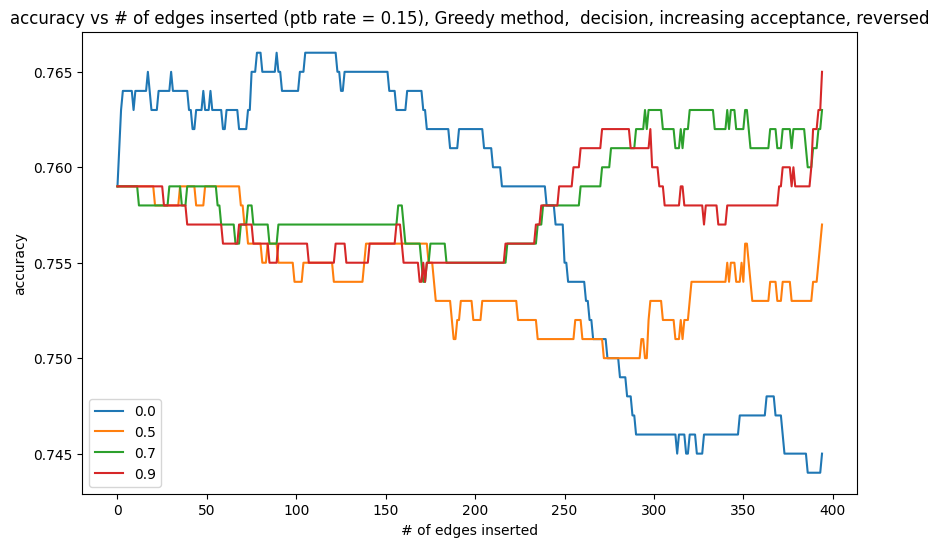

In [19]:
plot_results(split_dic_decreasing_acc, ptb_rate, "Greedy", "", "increasing", "accuracy", "reversed")

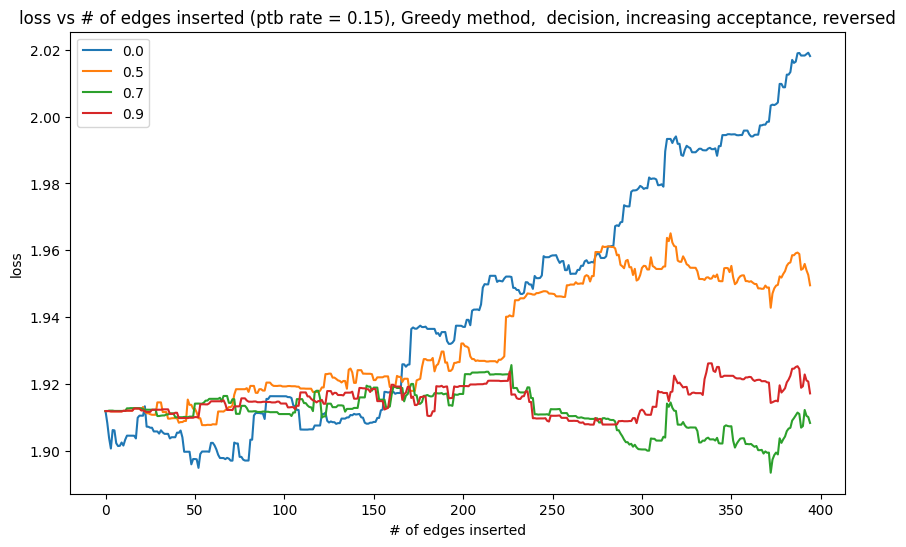

In [20]:
plot_results(split_dic_decreasing_loss, ptb_rate, "Greedy", "", "increasing", "loss", "reversed")

# regular, secondary attack, not reversed

In [21]:
splits = [0.0, 0.5, 0.7, 0.9]
# splits = [0.9]
split_dic_acc = defaultdict(list)
split_dic_loss = defaultdict(list)
itrs_one = defaultdict(int)

In [23]:
for s in splits:
    if s == 0.0:
        split_dic_acc[s], split_dic_loss[s], itrs_one[s] = full_metattack_acc, full_metattack_loss, full_metattack_itrs
    else:
        split_dic_acc[s], split_dic_loss[s], itrs_one[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, constant_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/197 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 16, Selected: 10
Attempt: 26, Selected: 20
Attempt: 36, Selected: 30
Attempt: 46, Selected: 40
Attempt: 56, Selected: 50
Attempt: 66, Selected: 60
Attempt: 76, Selected: 70
Attempt: 87, Selected: 80
Attempt: 97, Selected: 90
Attempt: 107, Selected: 100
Attempt: 117, Selected: 110
Attempt: 127, Selected: 120
Attempt: 137, Selected: 130
Attempt: 147, Selected: 140
Attempt: 157, Selected: 150
Attempt: 167, Selected: 160
Attempt: 177, Selected: 170
Attempt: 187, Selected: 180
Attempt: 197, Selected: 190


Peturbing graph...:   0%|          | 0/203 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/118 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 11, Selected: 10
Attempt: 21, Selected: 20
Attempt: 31, Selected: 30
Attempt: 41, Selected: 40
Attempt: 51, Selected: 50
Attempt: 61, Selected: 60
Attempt: 71, Selected: 70
Attempt: 81, Selected: 80
Attempt: 91, Selected: 90
Attempt: 101, Selected: 100
Attempt: 111, Selected: 110
Attempt: 121, Selected: 120
Attempt: 131, Selected: 130
Attempt: 142, Selected: 140
Attempt: 152, Selected: 150
Attempt: 162, Selected: 160
Attempt: 172, Selected: 170
Attempt: 183, Selected: 180
Attempt: 193, Selected: 190
Attempt: 203, Selected: 200
Attempt: 213, Selected: 210
Attempt: 223, Selected: 220
Attempt: 233, Selected: 230
Attempt: 243, Selected: 240
Attempt: 253, Selected: 250
Attempt: 263, Selected: 260
Attempt: 273, Selected: 270


Peturbing graph...:   0%|          | 0/123 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/39 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 11, Selected: 10
Attempt: 21, Selected: 20
Attempt: 31, Selected: 30
Attempt: 41, Selected: 40
Attempt: 51, Selected: 50
Attempt: 61, Selected: 60
Attempt: 71, Selected: 70
Attempt: 81, Selected: 80
Attempt: 91, Selected: 90
Attempt: 101, Selected: 100
Attempt: 111, Selected: 110
Attempt: 121, Selected: 120
Attempt: 131, Selected: 130
Attempt: 142, Selected: 140
Attempt: 152, Selected: 150
Attempt: 162, Selected: 160
Attempt: 172, Selected: 170
Attempt: 183, Selected: 180
Attempt: 193, Selected: 190
Attempt: 203, Selected: 200
Attempt: 213, Selected: 210
Attempt: 223, Selected: 220
Attempt: 233, Selected: 230
Attempt: 243, Selected: 240
Attempt: 253, Selected: 250
Attempt: 263, Selected: 260
Attempt: 273, Selected: 270
Attempt: 283, Selected: 280
Attempt: 293, Selected: 290
Attempt: 305, Selected: 300
Attempt: 315, Selected: 310
Attempt: 325, Selected: 320
Attempt: 335, Selected: 330
Attempt: 345, Selected: 340
Attempt: 356, Sele

Peturbing graph...:   0%|          | 0/41 [00:00<?, ?it/s]

In [24]:
record1 = Recording(split_dic_loss, split_dic_acc, itrs_one, Model.GCN, Dataset.CORA, AcceptFn.CONSTANT, SelectFn.NONE, Reverse.ATTACKED)
record1.save(f'data_collection/{"greedy"}_{"gcn"}_{"cora"}_{"constant"}_{"attacked"}_results.pkl')

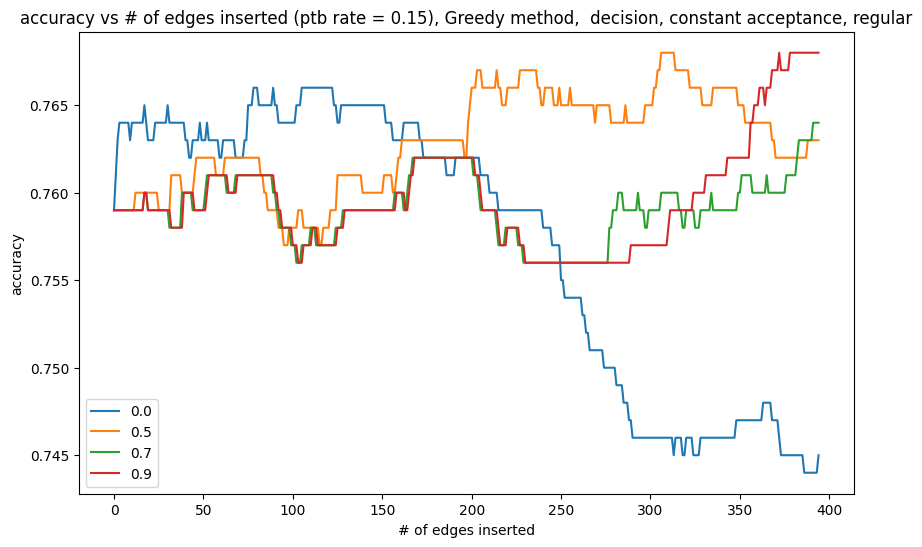

In [25]:
plot_results(split_dic_acc, ptb_rate, "Greedy", "", "constant", "accuracy", "regular")

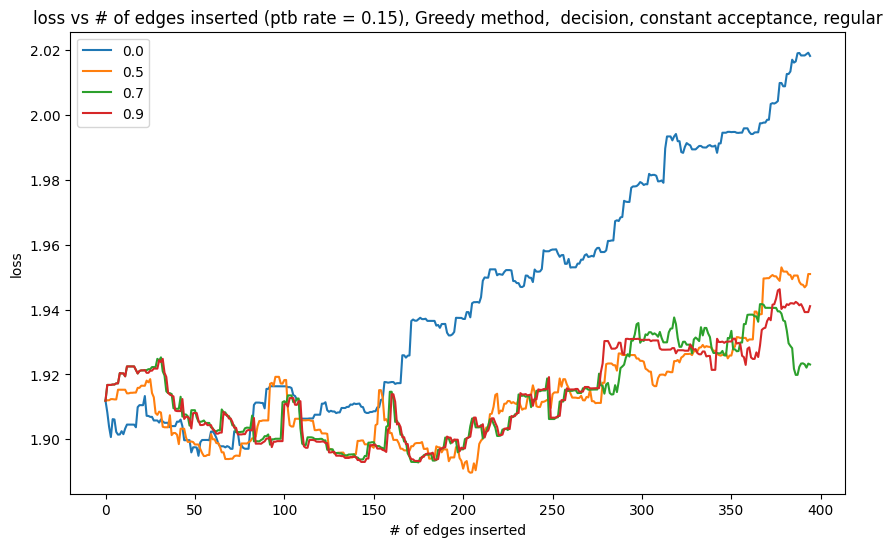

In [26]:
plot_results(split_dic_loss, ptb_rate, "Greedy", "", "constant", "loss", "regular")

##### ideally, we could show some metric, where (change in loss after hidden for %) > (% * max change in loss)

In [27]:
split_dic_decreasing_acc = defaultdict(list)
itrs_two = defaultdict(int)
split_dic_decreasing_loss = defaultdict(list)

In [28]:
for s in splits:
    if s == 0.0:
        split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = full_metattack_acc, full_metattack_loss, full_metattack_itrs
    else:
        split_dic_decreasing_acc[s], split_dic_decreasing_loss[s], itrs_two[s] = two_phase_attack_greedy(data, train, model, s, edges_to_add, increasing_fn, device, is_reversed=False, verbose=True)

Peturbing graph...:   0%|          | 0/197 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 5, Selected: 0
Attempt: 20, Selected: 10
Attempt: 30, Selected: 20
Attempt: 45, Selected: 30
Attempt: 58, Selected: 40
Attempt: 69, Selected: 50
Attempt: 79, Selected: 60
Attempt: 90, Selected: 70
Attempt: 101, Selected: 80
Attempt: 113, Selected: 90
Attempt: 123, Selected: 100
Attempt: 124, Selected: 100
Attempt: 135, Selected: 110
Attempt: 145, Selected: 120
Attempt: 155, Selected: 130
Attempt: 167, Selected: 140
Attempt: 178, Selected: 150
Attempt: 189, Selected: 160
Attempt: 199, Selected: 170
Attempt: 209, Selected: 180
Attempt: 219, Selected: 190


Peturbing graph...:   0%|          | 0/203 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/118 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 5, Selected: 0
Attempt: 20, Selected: 10
Attempt: 21, Selected: 10
Attempt: 40, Selected: 20
Attempt: 56, Selected: 30
Attempt: 57, Selected: 30
Attempt: 58, Selected: 30
Attempt: 73, Selected: 40
Attempt: 74, Selected: 40
Attempt: 85, Selected: 50
Attempt: 99, Selected: 60
Attempt: 99, Selected: 60
Attempt: 100, Selected: 60
Attempt: 112, Selected: 70
Attempt: 122, Selected: 80
Attempt: 134, Selected: 90
Attempt: 144, Selected: 100
Attempt: 155, Selected: 110
Attempt: 167, Selected: 120
Attempt: 177, Selected: 130
Attempt: 188, Selected: 140
Attempt: 199, Selected: 150
Attempt: 210, Selected: 160
Attempt: 221, Selected: 170
Attempt: 231, Selected: 180
Attempt: 241, Selected: 190
Attempt: 253, Selected: 200
Attempt: 265, Selected: 210
Attempt: 275, Selected: 220
Attempt: 286, Selected: 230
Attempt: 296, Selected: 240
Attempt: 307, Selected: 250
Attempt: 319, 

Peturbing graph...:   0%|          | 0/123 [00:00<?, ?it/s]

Peturbing graph...:   0%|          | 0/39 [00:00<?, ?it/s]

Attempt: 0, Selected: 0
Attempt: 1, Selected: 0
Attempt: 2, Selected: 0
Attempt: 3, Selected: 0
Attempt: 4, Selected: 0
Attempt: 5, Selected: 0
Attempt: 21, Selected: 10
Attempt: 37, Selected: 20
Attempt: 52, Selected: 30
Attempt: 53, Selected: 30
Attempt: 54, Selected: 30
Attempt: 66, Selected: 40
Attempt: 67, Selected: 40
Attempt: 81, Selected: 50
Attempt: 92, Selected: 60
Attempt: 93, Selected: 60
Attempt: 94, Selected: 60
Attempt: 95, Selected: 60
Attempt: 106, Selected: 70
Attempt: 107, Selected: 70
Attempt: 119, Selected: 80
Attempt: 130, Selected: 90
Attempt: 141, Selected: 100
Attempt: 151, Selected: 110
Attempt: 163, Selected: 120
Attempt: 164, Selected: 120
Attempt: 165, Selected: 120
Attempt: 176, Selected: 130
Attempt: 188, Selected: 140
Attempt: 199, Selected: 150
Attempt: 209, Selected: 160
Attempt: 220, Selected: 170
Attempt: 230, Selected: 180
Attempt: 240, Selected: 190
Attempt: 250, Selected: 200
Attempt: 251, Selected: 200
Attempt: 251, Selected: 200
Attempt: 252, Se

Peturbing graph...:   0%|          | 0/41 [00:00<?, ?it/s]

In [29]:
record1 = Recording(split_dic_decreasing_loss, split_dic_decreasing_acc, itrs_two, Model.GCN, Dataset.CORA, AcceptFn.INCREASING, SelectFn.NONE, Reverse.ATTACKED)
record1.save(f'data_collection/{"mcmc"}_{"gcn"}_{"cora"}_{"increasing"}_{"attacked"}_results.pkl')

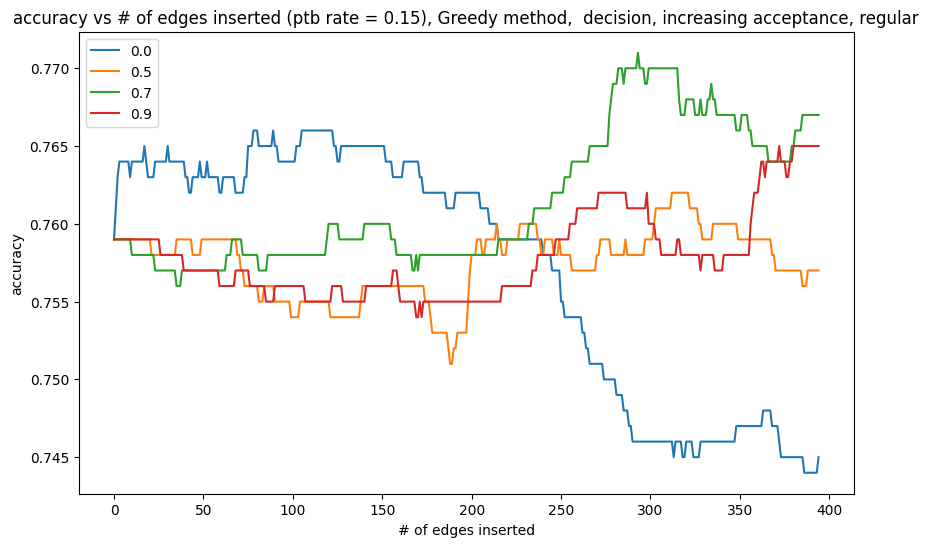

In [30]:
plot_results(split_dic_decreasing_acc, ptb_rate, "Greedy", "", "increasing", "accuracy", "regular")

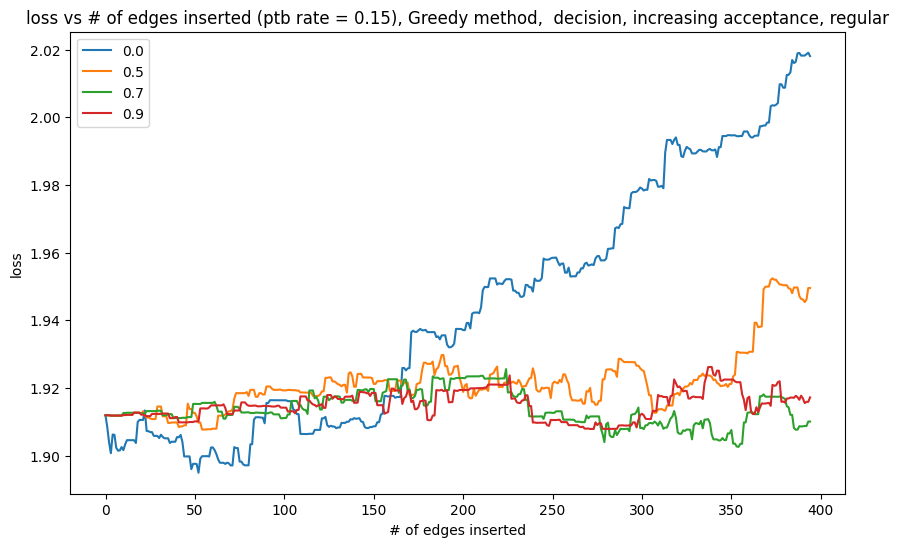

In [31]:
plot_results(split_dic_decreasing_loss, ptb_rate, "Greedy", "", "increasing", "loss", "regular")